In [1]:
from datetime import datetime
import time
from astropy.time import Time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from lsst_efd_client import EfdClient

EFD PYTHON CLIENT - USDF METHODS

In [2]:
# The EFD Python client for the USDF environment
efd_client = EfdClient(efd_name="usdf_efd")

#list of available methods
methods = dir(efd_client)
print(methods)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_do_query', '_make_fields', '_parse_schema', 'auth', 'build_time_range_query', 'db_name', 'deployment', 'from_name', 'get_fields', 'get_schema', 'get_topics', 'influx_client', 'list_efd_names', 'query_history', 'schema_registry_url', 'select_packed_time_series', 'select_time_series', 'select_top_n', 'subclasses']


AVAILABLE TOPICS IN SAL SCRIPTS

In [3]:
#list of all available topics
av_topics = await efd_client.get_topics()
with open('av_topics.txt', 'w') as file:
    for topic in av_topics:
        file.write(topic + '\n')

df_av_topics = pd.DataFrame(av_topics)
df_av_topics.to_csv("av_topics.csv", index=False)  
df_av_topics

,0
0,l.MTM1M3.command_forceActuatorBumpTest
1,l.MTM1M3.command_killForceActuatorBumpTest
2,l.MTM1M3.logevent_forceActuatorBumpTestStatus
3,l.MTM1M3.logevent_hardpointTestStatus
4,l.MTM2.command_actuatorBumpTest
...,...
2358,lsst.sal.WeatherStation.weather
2359,lsst.sal.WeatherStation.windDirection
2360,lsst.sal.WeatherStation.windGustDirection
2361,lsst.sal.WeatherStation.windSpeed


AVAILABLE VARIABLES IN EACH TOPIC IN SAL SCRIPTS

In [4]:
# how to get all the variables available in a single topic in .txt and .csv, example  with MTM2
position = await efd_client.get_fields("lsst.sal.MTM2.position")

with open("position.txt", "w") as file:
    for field in position:
        file.write(field + "\n")

# data conversion in DataFrame pandas
df_position = pd.DataFrame(position)
df_position.to_csv("position.csv", index=False)
df_position

,0
0,private_efdStamp
1,private_host
2,private_identity
3,private_kafkaStamp
4,private_origin
5,private_rcvStamp
6,private_revCode
7,private_seqNum
8,private_sndStamp
9,x


LIST OF DICTIONARIES DESCRIBING THE FIELD FOR A SINGLE TOPIC

In [5]:
#how to get, from a given topic, a list of dictionaries describing the fields, example for the position of MTM2
mtm2pos = await efd_client.get_schema("lsst.sal.MTM2.position")

with open("mtm2pos.txt", 'w') as file:
    for schema in mtm2pos:
        file.write(schema + "\n")

df_mtm2pos = pd.DataFrame(mtm2pos)
df_mtm2pos.to_csv("MTM2_position_schema.csv", index=False)
df_mtm2pos

,name,description,units,aunits,is_array
0,private_efdStamp,UTC time for EFD timestamp. An integer (the nu...,second,s,False
1,private_kafkaStamp,TAI time at which the Kafka message was created.,second,s,False
2,private_revCode,Revision hashcode,unitless,,False
3,private_sndStamp,Time of instance publication,second,s,False
4,private_rcvStamp,Time of instance reception,second,s,False
5,private_seqNum,Sequence number,unitless,,False
6,private_identity,Identity of publisher,unitless,,False
7,private_origin,PID of publisher,unitless,,False
8,x,Position x.,micron,micron,False
9,y,Position y.,micron,micron,False


COMPLETE LIST OD DICTIONARIES DESCRIBING THE FIELDS FOR ALL AVAILABLE TOPICS

In [6]:
# how to get, from all the available topics, the corresponding lists of dictionaries describing the fields

async def main():
    topics = await efd_client.get_topics()

    with open('topics.txt', 'w') as file:
        for topic in topics:
            file.write(topic + '\n')

    with open('schema.txt', 'w') as file_schema:
        with open('schema.csv', 'w') as file_csv:
           for topic in topics:
              try:
                 schema = await efd_client.get_schema(topic)
                 file_schema.write(f"Schema per il topic '{topic}':\n")
                 file_schema.write(str(schema) + '\n\n')

                 file_csv.write(f"{topic},{schema}\n")

                 df_topics = pd.DataFrame(topics)
                 df_topics.to_csv("topics.csv", index=False)
                
                 if schema:
                     df_schema = pd.DataFrame(schema)
                     df_schema.to_csv(f"schema_{topic}.csv", index=False)
                     print(f"Salvato schema_{topic}.csv")

              except:
                  pass  # to skip void topics

await main()


TIME SERIES - SAMPLES IN A SPECIFIC TIME INTERVAL

In [7]:
# we define a time interval, example on February 2024
t_start = Time("2024-02-23T19:20:00", scale="utc", format="isot")
t_end = Time("2024-02-23T19:25:00", scale="utc", format="isot")
# please use t_end2 in order to have a shorter time interval when necessary
t_end2=Time("2024-02-23T19:21:00", scale="utc", format="isot") 

MTM2

POSITION - (x,y,z) - (xRot,yRot,zRot)

In [8]:
# how to select a time series for a set of topics in a single subsystem, example on lsst.sal.MTM2.position
MTM2posTime = await efd_client.select_time_series("lsst.sal.MTM2.position",
    fields=["x","xRot","y","yRot","z","zRot","private_efdStamp","private_host","private_identity", "private_kafkaStamp",
"private_origin","private_rcvStamp","private_revCode","private_seqNum","private_sndStamp"],
    start=t_start,
    end=t_end
)

MTM2posTime.to_csv("MTM2_position_Time_series.csv")
MTM2posTime

,x,xRot,y,yRot,z,zRot,private_efdStamp,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp
2024-02-23 19:20:00.005327+00:00,-0.09,0,-0.76,0,0,0.01,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,3d5ef1af,6369472,1.708716e+09
2024-02-23 19:20:00.202694+00:00,-0.09,0,-0.76,0,0,0.01,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,3d5ef1af,6369473,1.708716e+09
2024-02-23 19:20:00.400641+00:00,-0.09,0,-0.76,0,0,0.01,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,3d5ef1af,6369474,1.708716e+09
2024-02-23 19:20:00.600401+00:00,-0.09,0,-0.76,0,0,0.01,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,3d5ef1af,6369475,1.708716e+09
2024-02-23 19:20:00.801134+00:00,-0.09,0,-0.76,0,0,0.01,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,3d5ef1af,6369476,1.708716e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23 19:24:59.206809+00:00,-0.09,0,-0.76,0,0,0.01,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,3d5ef1af,6371045,1.708716e+09
2024-02-23 19:24:59.402806+00:00,-0.09,0,-0.76,0,0,0.01,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,3d5ef1af,6371046,1.708716e+09
2024-02-23 19:24:59.520946+00:00,-0.09,0,-0.76,0,0,0.01,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,3d5ef1af,6371047,1.708716e+09
2024-02-23 19:24:59.720995+00:00,-0.09,0,-0.76,0,0,0.01,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,3d5ef1af,6371048,1.708716e+09


NET MOMENT OF FORCE IN x,y,z DIRECTION: mx, my, mz

In [9]:
#example  on lsst.sal.MTM2.netMomentsTotal
net_moments_tot_schema=await efd_client.get_schema("lsst.sal.MTM2.netMomentsTotal")
net_moments_tot_schema.to_csv("MTM2_net_moments_total_schema.csv")
net_moments_tot_schema

,name,description,units,aunits,is_array
0,private_efdStamp,UTC time for EFD timestamp. An integer (the nu...,second,s,False
1,private_kafkaStamp,TAI time at which the Kafka message was created.,second,s,False
2,private_revCode,Revision hashcode,unitless,,False
3,private_sndStamp,Time of instance publication,second,s,False
4,private_rcvStamp,Time of instance reception,second,s,False
5,private_seqNum,Sequence number,unitless,,False
6,private_identity,Identity of publisher,unitless,,False
7,private_origin,PID of publisher,unitless,,False
8,mx,Net moment of force in x direction.,newton*meter,N m,False
9,my,Net moment of force in y direction.,newton*meter,N m,False


In [10]:
# how to select a time series for a set of topics in a single subsystem, example  on lsst.sal.MTM2.netMomentsTotal
net_moments_total = await efd_client.select_time_series("lsst.sal.MTM2.netMomentsTotal",
    fields=["mx","my","mz","private_efdStamp","private_host","private_identity","private_kafkaStamp",
"private_origin","private_rcvStamp","private_revCode","private_seqNum","private_sndStamp"],
    start=t_start,
    end=t_end)
net_moments_total.to_csv("MTM2_net_moments_total_time_series.csv")
net_moments_total

,mx,my,mz,private_efdStamp,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp
2024-02-23 19:20:00.192669+00:00,421.43,30.24,-47.01,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,5175c6ac,6369462,1.708716e+09
2024-02-23 19:20:00.390428+00:00,423.98,18.98,-31.19,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,5175c6ac,6369463,1.708716e+09
2024-02-23 19:20:00.589490+00:00,424.42,20.69,-36.75,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,5175c6ac,6369464,1.708716e+09
2024-02-23 19:20:00.790327+00:00,424.15,16.09,-25.16,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,5175c6ac,6369465,1.708716e+09
2024-02-23 19:20:00.908200+00:00,423.77,31.57,-48.26,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,5175c6ac,6369466,1.708716e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23 19:24:59.196176+00:00,459.37,18.18,-37.44,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,5175c6ac,6371034,1.708716e+09
2024-02-23 19:24:59.391815+00:00,459.50,18.90,-34.58,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,5175c6ac,6371035,1.708716e+09
2024-02-23 19:24:59.511288+00:00,460.65,26.53,-36.11,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,5175c6ac,6371036,1.708716e+09
2024-02-23 19:24:59.711043+00:00,460.09,20.18,-44.08,1.708716e+09,None,MTM2,1.708716e+09,3626902,1.708716e+09,5175c6ac,6371037,1.708716e+09


INDIVIDUAL TANGENTIAL LINK FOR FORCE EXCESS - TOTAL MIRROR TANGENTIAL FORCE EXCESS - SUMMATION OF THE TOTAL CURRENT FORCES OF TANGENTIAL LINKS - force, weight, sum


In [11]:
#example on lsst.sal.MTM2.forceErrorTangent
forceErrorTangent_schema=await efd_client.get_schema("lsst.sal.MTM2.forceErrorTangent")
forceErrorTangent_schema.to_csv("MTM2_forceErrorTangent.csv")
forceErrorTangent_schema

,name,description,units,aunits,is_array
0,private_efdStamp,UTC time for EFD timestamp. An integer (the nu...,second,s,False
1,private_kafkaStamp,TAI time at which the Kafka message was created.,second,s,False
2,private_revCode,Revision hashcode,unitless,,False
3,private_sndStamp,Time of instance publication,second,s,False
4,private_rcvStamp,Time of instance reception,second,s,False
5,private_seqNum,Sequence number,unitless,,False
6,private_identity,Identity of publisher,unitless,,False
7,private_origin,PID of publisher,unitless,,False
8,force,Individual tangential link force excess. Calcu...,newton,N,True
9,weight,Total mirror tangential force excess. Calculat...,newton,N,False


In [12]:
#example on lsst.sal.MTM2.forceErrorTangent
forceErrorTangent = await efd_client.select_time_series("lsst.sal.MTM2.forceErrorTangent",
    fields=["sum","weight","force0", "force1", "force2", "force3", "force4", "force5", "private_efdStamp",
 "private_identity","private_kafkaStamp","private_origin","private_rcvStamp","private_revCode",
 "private_seqNum","private_sndStamp"],
    start=t_start,
    end=t_end)
forceErrorTangent .to_csv("MTM2_forceErrorTangent_time_series .csv")
forceErrorTangent

,sum,weight,force0,force1,force2,force3,force4,force5,private_efdStamp,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp
2024-02-23 19:20:00.118830+00:00,-26.41,145.67,42.82,-106.19,5.60,-5.12,30.75,14.33,1.708716e+09,MTM2,1.708716e+09,3626902,1.708716e+09,b9e7700c,5778948,1.708716e+09
2024-02-23 19:20:00.317016+00:00,-17.52,144.54,45.78,-103.38,3.98,-0.65,31.44,13.70,1.708716e+09,MTM2,1.708716e+09,3626902,1.708716e+09,b9e7700c,5778949,1.708716e+09
2024-02-23 19:20:00.515903+00:00,-20.65,144.77,46.80,-104.64,4.78,-3.99,30.50,14.40,1.708716e+09,MTM2,1.708716e+09,3626902,1.708716e+09,b9e7700c,5778950,1.708716e+09
2024-02-23 19:20:00.718050+00:00,-14.13,145.98,47.93,-105.28,7.49,-4.80,32.68,15.51,1.708716e+09,MTM2,1.708716e+09,3626902,1.708716e+09,b9e7700c,5778951,1.708716e+09
2024-02-23 19:20:01.030915+00:00,-21.78,147.25,45.51,-104.41,2.02,-0.86,31.53,13.33,1.708716e+09,MTM2,1.708716e+09,3626902,1.708716e+09,b9e7700c,5778952,1.708716e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23 19:24:58.921341+00:00,-29.11,151.57,40.50,-108.76,4.48,-3.83,31.12,16.18,1.708716e+09,MTM2,1.708716e+09,3626902,1.708716e+09,b9e7700c,5780366,1.708716e+09
2024-02-23 19:24:59.120360+00:00,-21.03,150.29,39.86,-105.19,3.39,0.65,32.02,16.48,1.708716e+09,MTM2,1.708716e+09,3626902,1.708716e+09,b9e7700c,5780367,1.708716e+09
2024-02-23 19:24:59.321038+00:00,-19.43,145.64,44.60,-104.64,4.31,-0.49,31.66,13.64,1.708716e+09,MTM2,1.708716e+09,3626902,1.708716e+09,b9e7700c,5780368,1.708716e+09
2024-02-23 19:24:59.635532+00:00,-24.76,144.50,42.06,-107.00,6.89,-2.48,31.60,12.79,1.708716e+09,MTM2,1.708716e+09,3626902,1.708716e+09,b9e7700c,5780369,1.708716e+09


TEMPERATURE - rings

In [13]:
# Example  on "lsst.sal.MTM2.temperature
temperature_schema = await efd_client.get_schema("lsst.sal.MTM2.temperature")
temperature_schema.to_csv("MTM2_temperature_schema.csv")
temperature_schema

,name,description,units,aunits,is_array
0,private_efdStamp,UTC time for EFD timestamp. An integer (the nu...,second,s,False
1,private_kafkaStamp,TAI time at which the Kafka message was created.,second,s,False
2,private_revCode,Revision hashcode,unitless,,False
3,private_sndStamp,Time of instance publication,second,s,False
4,private_rcvStamp,Time of instance reception,second,s,False
5,private_seqNum,Sequence number,unitless,,False
6,private_identity,Identity of publisher,unitless,,False
7,private_origin,PID of publisher,unitless,,False
8,ring,"Ring temperatures: LG2-1, LG2-2, LG2-3, LG2-4,...",deg_C,deg_C,True
9,intake,Intake temperatures: #1 and #2.,deg_C,deg_C,True


In [14]:
# Example on "lsst.sal.MTM2.temperature
temperature_ring = await efd_client.select_time_series(
        "lsst.sal.MTM2.temperature",
        fields=["ring0", "ring1", "ring2","ring3","ring4","ring5","ring6","ring7","ring8","ring9","ring10","ring11"],
        start=t_start,
        end=t_end)

# retrieves the from 12 ring temperature sensors
temperature_ring.to_csv("MTM2_temperature_ring.csv")
temperature_ring

,ring0,ring1,ring2,ring3,ring4,ring5,ring6,ring7,ring8,ring9,ring10,ring11
2024-02-23 19:20:00.037803+00:00,13.73,13.61,13.63,13.65,13.50,12.98,13.03,12.94,13.57,13.56,13.73,13.79
2024-02-23 19:20:00.234872+00:00,13.73,13.61,13.63,13.65,13.50,12.98,13.03,12.94,13.57,13.56,13.73,13.79
2024-02-23 19:20:00.431919+00:00,13.73,13.61,13.63,13.65,13.50,12.98,13.03,12.94,13.57,13.56,13.73,13.79
2024-02-23 19:20:00.631440+00:00,13.73,13.61,13.63,13.65,13.50,12.98,13.03,12.94,13.57,13.56,13.73,13.79
2024-02-23 19:20:00.831238+00:00,13.73,13.61,13.63,13.65,13.50,12.98,13.03,12.94,13.57,13.56,13.73,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-23 19:24:59.238903+00:00,13.74,13.61,13.64,13.65,13.51,12.99,13.04,12.95,13.58,13.57,13.74,13.80
2024-02-23 19:24:59.432903+00:00,13.74,13.61,13.64,13.65,13.51,12.99,13.04,12.95,13.58,13.57,13.74,13.80
2024-02-23 19:24:59.551355+00:00,13.74,13.61,13.64,13.65,13.51,12.99,13.04,12.95,13.58,13.57,13.74,13.80
2024-02-23 19:24:59.751644+00:00,13.74,13.61,13.64,13.65,13.51,12.99,13.04,12.95,13.58,13.57,13.74,13.80


POWER STATUS - total motor Voltage, total motor Current, total communication Voltage, total communication current

In [15]:
# Example  on "lsst.sal.MTM2.powerStatus
powerStatus_schema=await efd_client.get_schema("lsst.sal.MTM2.powerStatus")
powerStatus_schema.to_csv("MTM2_powerStatus_schema.csv")
powerStatus_schema

,name,description,units,aunits,is_array
0,private_efdStamp,UTC time for EFD timestamp. An integer (the nu...,second,s,False
1,private_kafkaStamp,TAI time at which the Kafka message was created.,second,s,False
2,private_revCode,Revision hashcode,unitless,,False
3,private_sndStamp,Time of instance publication,second,s,False
4,private_rcvStamp,Time of instance reception,second,s,False
5,private_seqNum,Sequence number,unitless,,False
6,private_identity,Identity of publisher,unitless,,False
7,private_origin,PID of publisher,unitless,,False
8,motorVoltage,Total motor voltage.,volt,V,False
9,motorCurrent,Total motor current.,ampere,A,False


In [16]:
# Example on "lsst.sal.MTM2.powerStatus
powerStatus = await efd_client.select_time_series("lsst.sal.MTM2.powerStatus",
        fields=["motorVoltage","motorCurrent","commVoltage","commCurrent"],
        start=t_start,
        end=t_end)
powerStatus.to_csv("MTM2_powerStatus.csv")
powerStatus

,motorVoltage,motorCurrent,commVoltage,commCurrent
2024-02-23 19:20:00.108541+00:00,23.79,12.43,23.88,6.50
2024-02-23 19:20:00.306396+00:00,23.82,12.43,23.82,6.49
2024-02-23 19:20:00.505348+00:00,23.82,12.38,23.85,6.49
2024-02-23 19:20:00.707135+00:00,23.79,12.28,23.85,6.51
2024-02-23 19:20:01.020543+00:00,23.79,12.23,23.85,6.49
...,...,...,...,...
2024-02-23 19:24:58.910595+00:00,23.79,12.28,23.85,6.49
2024-02-23 19:24:59.109616+00:00,23.79,12.28,23.85,6.49
2024-02-23 19:24:59.310929+00:00,23.79,12.18,23.85,6.46
2024-02-23 19:24:59.625192+00:00,23.85,12.20,23.91,6.52


,motorVoltage
2024-02-23 19:20:00.108541+00:00,23.79
2024-02-23 19:20:00.306396+00:00,23.82
2024-02-23 19:20:00.505348+00:00,23.82
2024-02-23 19:20:00.707135+00:00,23.79
2024-02-23 19:20:01.020543+00:00,23.79
...,...
2024-02-23 19:20:59.165923+00:00,23.79
2024-02-23 19:20:59.361623+00:00,23.85
2024-02-23 19:20:59.559926+00:00,23.79
2024-02-23 19:20:59.761579+00:00,23.82


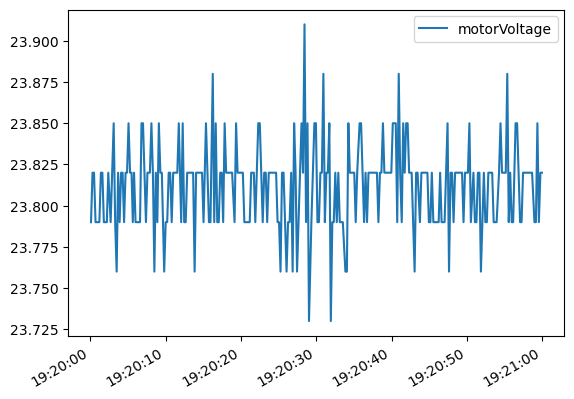

In [17]:
# how to build a query based on a time range
query_motorVoltage =efd_client.build_time_range_query("lsst.sal.MTM2.powerStatus", fields=["motorVoltage"], start=t_start, end=t_end2)
motorVoltage = await efd_client.influx_client.query(query_motorVoltage)
motorVoltage.plot(y="motorVoltage")
plt.savefig("Motor Voltage.pdf")
motorVoltage.to_csv("motorVoltage.csv")
motorVoltage

 M1M3

imsDATA: (x,y,z) position - (x,y,z) rotation

In [18]:
#example on lsst.sal.MTM1M3.imsData
MTM1M3imsData_schema=await efd_client.get_schema("lsst.sal.MTM1M3.imsData")
MTM1M3imsData_schema.to_csv("MTM1M3imsData_schema.csv")
MTM1M3imsData_schema

,name,description,units,aunits,is_array
0,private_efdStamp,UTC time for EFD timestamp. An integer (the nu...,second,s,False
1,private_kafkaStamp,TAI time at which the Kafka message was created.,second,s,False
2,private_revCode,Revision hashcode,unitless,,False
3,private_sndStamp,Time of instance publication,second,s,False
4,private_rcvStamp,Time of instance reception,second,s,False
5,private_seqNum,Sequence number,unitless,,False
6,private_identity,Identity of publisher,unitless,,False
7,private_origin,PID of publisher,unitless,,False
8,timestamp,IMS Data timestamp.,s,s,False
9,rawSensorData,IMS Data raw Sensor Date.,unitless,,True


In [19]:
#example on lsst.sal.MTM1M3.imsData
MTM1M3_imsData = await efd_client.select_time_series("lsst.sal.MTM1M3.imsData",
        fields=["timestamp","rawSensorData0", "xPosition", "xRotation", "yPosition", "yRotation", "zPosition",
 "zRotation"],
        start=Time("2023-05-3T15:24:00", scale="utc", format="isot"),#specific date on usdf chronograf
        end=Time("2023-05-3T15:30:00", scale="utc", format="isot")) 
MTM1M3_imsData.to_csv("MTM1M3_imsData.csv")
MTM1M3_imsData

,timestamp,rawSensorData0,xPosition,xRotation,yPosition,yRotation,zPosition,zRotation
2023-05-03 15:24:00.012328+00:00,1.683127e+09,25.941500,-0.001547,0.000621,0.005482,-0.006801,-0.006256,0.009373
2023-05-03 15:24:00.032329+00:00,1.683127e+09,25.941500,-0.001547,0.000621,0.005482,-0.006801,-0.006256,0.009373
2023-05-03 15:24:00.052351+00:00,1.683127e+09,25.941500,-0.001547,0.000621,0.005482,-0.006801,-0.006256,0.009373
2023-05-03 15:24:00.072329+00:00,1.683127e+09,25.941500,-0.001547,0.000621,0.005482,-0.006801,-0.006256,0.009373
2023-05-03 15:24:00.112317+00:00,1.683127e+09,25.941500,-0.001547,0.000621,0.005482,-0.006801,-0.006256,0.009373
...,...,...,...,...,...,...,...,...
2023-05-03 15:29:59.895188+00:00,1.683128e+09,25.939501,-0.001559,0.000532,0.005485,-0.006874,-0.006253,0.009681
2023-05-03 15:29:59.935216+00:00,1.683128e+09,25.939501,-0.001559,0.000532,0.005485,-0.006874,-0.006253,0.009681
2023-05-03 15:29:59.955263+00:00,1.683128e+09,25.939501,-0.001559,0.000532,0.005485,-0.006874,-0.006253,0.009681
2023-05-03 15:29:59.975243+00:00,1.683128e+09,25.939501,-0.001559,0.000532,0.005485,-0.006874,-0.006253,0.009679


AT CAMERA

POWER: analog/aux/clock high/clock low/DPHI/digital/fan/HV bias/OD/OTM current and voltage

In [20]:
#example on lsst.sal.ATCamera.power
ATcamera_schema=await efd_client.get_schema("lsst.sal.ATCamera.power")
ATcamera_schema.to_csv("ATcamera_schema.csv")
ATcamera_schema

,name,description,units,aunits,is_array
0,private_efdStamp,UTC time for EFD timestamp. An integer (the nu...,second,s,False
1,private_kafkaStamp,TAI time at which the Kafka message was created.,second,s,False
2,private_revCode,Revision hashcode,unitless,,False
3,private_sndStamp,Time of instance publication,second,s,False
4,private_rcvStamp,Time of instance reception,second,s,False
5,private_seqNum,Sequence number,unitless,,False
6,private_identity,Identity of publisher,unitless,,False
7,private_origin,PID of publisher,unitless,,False
8,analog_I,Analog current,mA,mA,False
9,analog_V,Analog voltage,Volt,V,False


In [21]:
#example on lsst.sal.ATCamera.power
ATCamera_power = await efd_client.select_time_series("lsst.sal.ATCamera.power",
        fields=["od_I","od_V","otm_I","od_I","analog_I","analog_V","aux_I","aux_V","clkhigh_I","clkhigh_V",
 "clklow_I","clklow_V","digital_I","digital_V","dphi_I","dphi_V","fan_I","fan_V","hvbias_I","hvbias_V"],
        start=Time("2023-05-3T15:24:00", scale="utc", format="isot"),#specific date on usdf chronograf
        end=Time("2023-05-3T15:25:00", scale="utc", format="isot")) 
ATCamera_power.to_csv("ATCamera_power_time_series.csv")
ATCamera_power

,od_I,od_V,otm_I,od_I_1,analog_I,analog_V,aux_I,aux_V,clkhigh_I,clkhigh_V,clklow_I,clklow_V,digital_I,digital_V,dphi_I,dphi_V,fan_I,fan_V,hvbias_I,hvbias_V
2023-05-03 15:24:10.478441+00:00,28.299999,32.049999,464.200012,28.299999,303.000000,7.2,0,0,30.299999,12,30.700001,12,668.599976,5.25,6.3,10,0,0,1.245312e-11,-50
2023-05-03 15:24:20.448747+00:00,28.299999,32.049999,464.100006,28.299999,303.000000,7.2,0,0,30.299999,12,30.700001,12,675.400024,5.25,6.3,10,0,0,4.724912e-12,-50
2023-05-03 15:24:31.446332+00:00,28.299999,32.049999,464.200012,28.299999,303.000000,7.2,0,0,30.299999,12,30.700001,12,668.599976,5.25,6.3,10,0,0,-1.805295e-11,-50
2023-05-03 15:24:38.051650+00:00,28.299999,32.049999,464.200012,28.299999,309.899994,7.2,0,0,30.299999,12,30.700001,12,675.400024,5.25,6.3,10,0,0,1.041939e-11,-50
2023-05-03 15:24:48.536646+00:00,28.299999,32.049999,464.299988,28.299999,303.000000,7.2,0,0,30.299999,12,30.700001,12,675.299988,5.25,6.3,10,0,0,-3.410036e-12,-50
2023-05-03 15:24:59.131264+00:00,28.299999,32.049999,464.299988,28.299999,309.899994,7.2,0,0,30.299999,12,30.700001,12,668.700012,5.25,6.3,10,0,0,8.589017e-12,-50


ATMCS - Auxiliary Telescope Mount Control System

MEASURED MOTOR VELOCITY

In [22]:
#example on lsst.sal.ATMCS.measuredMotorVelocity
#please find a time interval with data
ATMCS_measuredMotorVelocity_schema=await efd_client.get_schema("lsst.sal.ATMCS.measuredMotorVelocity")
ATMCS_measuredMotorVelocity_schema.to_csv("ATMCS_measuredMotorVelocity_schema.csv")
ATMCS_measuredMotorVelocity_schema


,name,description,units,aunits,is_array
0,private_efdStamp,UTC time for EFD timestamp. An integer (the nu...,second,s,False
1,private_kafkaStamp,TAI time at which the Kafka message was created.,second,s,False
2,private_revCode,Revision hashcode,unitless,,False
3,private_sndStamp,Time of instance publication,second,s,False
4,private_rcvStamp,Time of instance reception,second,s,False
5,private_seqNum,Sequence number,unitless,,False
6,private_identity,Identity of publisher,unitless,,False
7,private_origin,PID of publisher,unitless,,False
8,cRIO_timestamp,Time for the first sample of each telemetry it...,second,s,False
9,elevationMotorVelocity,Measured velocity of elevation drive motor at ...,deg/second,deg / s,True


In [23]:
#example on lsst.sal.ATMCS.measuredMotorVelocity
ATMCS_measuredMotorVelocity=await efd_client.select_time_series("lsst.sal.ATMCS.measuredMotorVelocity",
        fields=["elevationMotorVelocity","azimuthMotor1Velocity","azimuthMotor2Velocity","nasmyth1MotorVelocity",
 "nasmyth2MotorVelocity","m3Velocity"],
       start=Time("2023-05-3T15:24:00", scale="utc", format="isot"),#specific date on usdf chronograf
        end=Time("2023-05-3T15:25:00", scale="utc", format="isot"))  
ATMCS_measuredMotorVelocity.to_csv("ATMCS_measuredMotorVelocity_time_series.csv")
ATMCS_measuredMotorVelocity

""


MOUNT AzEl ENCODERS: Telemetry for elevation and azimuth encoders

In [24]:
#example on lsst.sal.ATMCS.mount_AzEl_Encoder
ATMCS_mount_AzEl_Encoders_schema = await efd_client.get_schema( "lsst.sal.ATMCS.mount_AzEl_Encoders")
ATMCS_mount_AzEl_Encoders_schema.to_csv("ATMCS_mount_AzEl_Encoders_schema.csv")
ATMCS_mount_AzEl_Encoders_schema

,name,description,units,aunits,is_array
0,private_efdStamp,UTC time for EFD timestamp. An integer (the nu...,second,s,False
1,private_kafkaStamp,TAI time at which the Kafka message was created.,second,s,False
2,private_revCode,Revision hashcode,unitless,,False
3,private_sndStamp,Time of instance publication,second,s,False
4,private_rcvStamp,Time of instance reception,second,s,False
5,private_seqNum,Sequence number,unitless,,False
6,private_identity,Identity of publisher,unitless,,False
7,private_origin,PID of publisher,unitless,,False
8,cRIO_timestamp,Time for the first sample of each telemetry it...,second,s,False
9,elevationCalculatedAngle,Elevation axis position computed from the axis...,deg,deg,True


In [25]:
warnings.filterwarnings("ignore") #how to ignore warning messages 

#example on lsst.sal.ATMCS.mount_AzEl_Encoder
ATMCS_mount_AzEl_Encoder = await efd_client.select_packed_time_series( "lsst.sal.ATMCS.mount_AzEl_Encoders", base_fields=["azimuthCalculatedAngle"], 
                                                  start=t_start, end=t_end)
ATMCS_mount_AzEl_Encoder.to_csv("ATMCS_mount_AzEl_Encoder.csv")

warnings.filterwarnings("default")

ATMCS_mount_AzEl_Encoder

,azimuthCalculatedAngle,times
2024-02-23 19:19:59.509643078,188.698957,1.708716e+09
2024-02-23 19:19:59.519643307,188.698950,1.708716e+09
2024-02-23 19:19:59.529643297,188.698948,1.708716e+09
2024-02-23 19:19:59.539643288,188.698943,1.708716e+09
2024-02-23 19:19:59.549643517,188.698947,1.708716e+09
...,...,...
2024-02-23 19:24:59.461306572,188.698946,1.708716e+09
2024-02-23 19:24:59.471306801,188.698943,1.708716e+09
2024-02-23 19:24:59.481307030,188.698942,1.708716e+09
2024-02-23 19:24:59.491307020,188.698945,1.708716e+09


    QUERIES WITH InfluxQL

AT CAMERA

CRYO VACUUM

In [26]:
#example on lsst.sal.ATCamera.vacuum
ATcamera_schema_vacuum=await efd_client.get_schema("lsst.sal.ATCamera.vacuum")
ATcamera_schema_vacuum.to_csv("ATcamera_vacuum_schema.csv")
ATcamera_schema_vacuum

,name,description,units,aunits,is_array
0,private_efdStamp,UTC time for EFD timestamp. An integer (the nu...,second,s,False
1,private_kafkaStamp,TAI time at which the Kafka message was created.,second,s,False
2,private_revCode,Revision hashcode,unitless,,False
3,private_sndStamp,Time of instance publication,second,s,False
4,private_rcvStamp,Time of instance reception,second,s,False
5,private_seqNum,Sequence number,unitless,,False
6,private_identity,Identity of publisher,unitless,,False
7,private_origin,PID of publisher,unitless,,False
8,tempCCD,CCD temperature,Celsius,deg_C,False
9,tempCCDSetPoint,Setpoint temperature,Celsius,deg_C,False


In [27]:
#example on lsst.sal.ATCamera.vacuum
ATCamera_vacuum = await efd_client.select_time_series("lsst.sal.ATCamera.vacuum",
        fields=["vacuum"], start=t_start,end= t_end) 
ATCamera_vacuum.to_csv("ATCamera_vacuum_time_series.csv")
ATCamera_vacuum

,vacuum
2024-02-23 19:20:02.389651+00:00,3.150000e-07
2024-02-23 19:20:12.382342+00:00,3.110000e-07
2024-02-23 19:20:22.390890+00:00,3.070000e-07
2024-02-23 19:20:32.391173+00:00,3.050000e-07
2024-02-23 19:20:42.369514+00:00,3.030000e-07
2024-02-23 19:20:52.388646+00:00,3.000000e-07
2024-02-23 19:21:02.374732+00:00,2.990000e-07
2024-02-23 19:21:12.367103+00:00,2.970000e-07
2024-02-23 19:21:22.376156+00:00,2.960000e-07
2024-02-23 19:21:32.475394+00:00,2.940000e-07


,vacuum
2024-02-23 19:20:02.389651+00:00,3.150000e-07
2024-02-23 19:20:12.382342+00:00,3.110000e-07
2024-02-23 19:20:22.390890+00:00,3.070000e-07
2024-02-23 19:20:32.391173+00:00,3.050000e-07
2024-02-23 19:20:42.369514+00:00,3.030000e-07
2024-02-23 19:20:52.388646+00:00,3.000000e-07
2024-02-23 19:21:02.374732+00:00,2.990000e-07
2024-02-23 19:21:12.367103+00:00,2.970000e-07
2024-02-23 19:21:22.376156+00:00,2.960000e-07
2024-02-23 19:21:32.475394+00:00,2.940000e-07


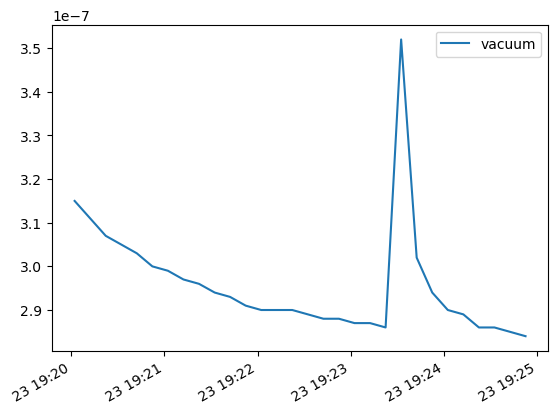

In [28]:
#example on lsst.sal.ATCamera.vacuum (Cryo Vacuum)
#starting from a known query with a specific time interval or with time relative the current time in UTC

query_vacuum =efd_client.build_time_range_query("lsst.sal.ATCamera.vacuum", fields=["vacuum"], start=t_start, end=t_end)
#query = '''SELECT vacuum FROM "lsst.sal.ATCamera.vacuum" WHERE time > now() - 1h '''
#query = '''SELECT vacuum FROM "lsst.sal.ATCamera.vacuum" WHERE time >  '2023-04-20' '''

vacuum = await efd_client.influx_client.query(query_vacuum)
vacuum.plot(y="vacuum")
plt.savefig("CryoVacuum.pdf")
vacuum.to_csv("CryoVacuum.csv")
vacuum

NET MOMENT OF FORCE IN x,y,z DIRECTION: mx, my, mz

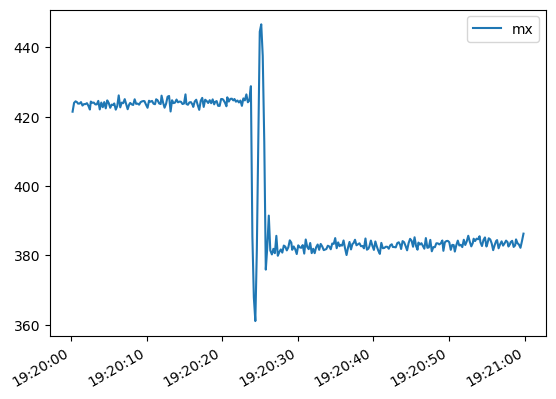

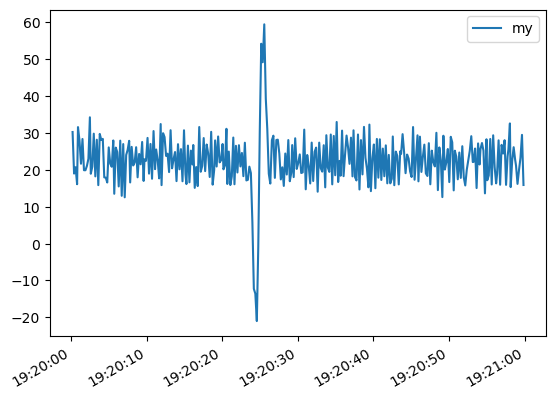

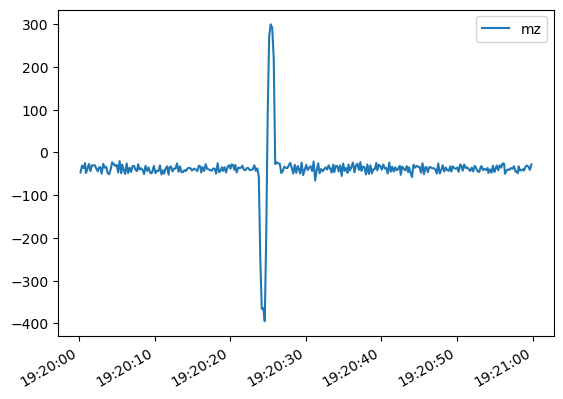

In [29]:
# example on lsst.sal.MTM2.netMomentsTotal
query_moments=efd_client.build_time_range_query("lsst.sal.MTM2.netMomentsTotal", 
                                         fields=["mx","my","mz"], start=t_start, end=t_end2)

moments=await efd_client.influx_client.query(query_moments)
moments.to_csv("Net Moment Force in the X-Y-Z Directions.csv")
moments

moments.plot(y="mx")
plt.savefig("Net Moment Force in the X Direction.pdf")

moments.plot(y="my")
plt.savefig("Net Moment Force in the Y Direction.pdf")

moments.plot(y="mz")
plt.savefig("Net Moment Force in the Z Direction.pdf")

HOW TO SELECT THE MOST RECENT N SAMPLES FROM A SET OF TOPICS IN A SINGLE SUBSYSTEM

In [30]:
#Select the most recent N samples from a set of topics in a single subsystem
#example on lsst.sal.MTM2.netMomentsTotal
moments_n_samples=await efd_client.select_top_n("lsst.sal.MTM2.netMomentsTotal", num=5, 
                                                fields=["mx","my","mz"])
moments_n_samples.to_csv("Moments N Samples.csv")
moments_n_samples

,mx,my,mz
2024-03-17 08:30:00.070788+00:00,1261.04,25.24,-231.67
2024-03-17 08:29:59.871360+00:00,1262.08,22.41,-223.98
2024-03-17 08:29:59.671503+00:00,1264.03,22.26,-235.10
2024-03-17 08:29:59.474388+00:00,1259.58,24.09,-226.98
2024-03-17 08:29:59.278734+00:00,1263.55,23.22,-237.32


ATPtg: component related to Auxiliary Telescope operations

MOUNT POSITION: Telemetry for mount positions in sky coordinate

In [31]:
#example on lsst.sal.ATPtg.mountPositions
ATPtg_mountPositions_schema = await efd_client.get_schema("lsst.sal.ATPtg.mountPositions")
ATPtg_mountPositions_schema.to_csv("ATPtg_mountPositions_schema.csv")
ATPtg_mountPositions_schema

,name,description,units,aunits,is_array
0,private_efdStamp,UTC time for EFD timestamp. An integer (the nu...,second,s,False
1,private_kafkaStamp,TAI time at which the Kafka message was created.,second,s,False
2,private_revCode,Revision hashcode,unitless,,False
3,private_sndStamp,Time of instance publication,second,s,False
4,private_rcvStamp,Time of instance reception,second,s,False
5,private_seqNum,Sequence number,unitless,,False
6,private_identity,Identity of publisher,unitless,,False
7,private_origin,PID of publisher,unitless,,False
8,cRioTimestamp,Time for the first sample of each telemetry it...,s,s,False
9,azimuthCalculatedAngle,Azimuth axis position reported by mount compon...,deg,deg,True


In [32]:
#example on lsst.sal.ATPtg.mountPositions
#please use ref_timestamp_col="cRioTimestamp"
warnings.filterwarnings("ignore")

mount_position_ATPtg_packed = await efd_client.select_packed_time_series("lsst.sal.ATPtg.mountPositions", 
 base_fields=["ra","declination","skyAngle"], start=t_start, end=t_end, ref_timestamp_col="cRioTimestamp")

mount_position_ATPtg_packed.to_csv("mount_position_ATPtg_packed.csv")
mount_position_ATPtg_packed

,ra,declination,skyAngle,times
2024-02-23 19:19:59.509643078,334.622217,-78.818249,3.538322,1.708716e+09
2024-02-23 19:19:59.519643307,334.622284,-78.818252,3.538291,1.708716e+09
2024-02-23 19:19:59.529643297,334.622345,-78.818250,3.538272,1.708716e+09
2024-02-23 19:19:59.539643288,334.622394,-78.818254,3.538263,1.708716e+09
2024-02-23 19:19:59.549643517,334.622424,-78.818252,3.538280,1.708716e+09
...,...,...,...,...
2024-02-23 19:24:59.461306572,335.888792,-78.819540,3.524500,1.708716e+09
2024-02-23 19:24:59.471306801,335.888828,-78.819545,3.524514,1.708716e+09
2024-02-23 19:24:59.481307030,335.888882,-78.819545,3.524497,1.708716e+09
2024-02-23 19:24:59.491307020,335.888912,-78.819543,3.524512,1.708716e+09
